## Introduction

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline for the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition. NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

If you're not familiar with naive bayes and bag of words matrices, I've made a preview available of one of fast.ai's upcoming *Practical Machine Learning* course videos, which introduces this topic. Here is a link to the section of the video which discusses this: [Naive Bayes video](https://youtu.be/37sFIak42Sc?t=3745).

In [ ]:
https://www.youtube.com/watch?v=37sFIak42Sc&feature=youtu.be&t=3745

In [12]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

In [13]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
subm = pd.read_csv('input/sample_submission.csv')

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [14]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [15]:
train['comment_text'][0]

"Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated."

In [16]:
train['comment_text'][2]

'"\n\n ""Points of interest"" \n\nI removed the ""points of interest"" section you added because it seemed kind of spammy. I know you probably didn\'t mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That\'s just my opinion, though.\n\nIf you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage.   "'

The length of the comments varies a lot.

In [17]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(395.3418639346486, 595.1020716997102, 5000)

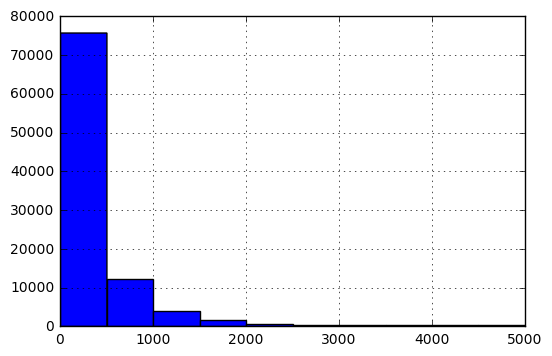

In [18]:
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [19]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,9.585100e+04,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000
mean,4.994359e+11,0.096368,0.010068,0.053301,0.003182,0.049713,0.008492,0.897862
std,2.890136e+11,0.295097,0.099832,0.224635,0.056320,0.217352,0.091762,0.302831
min,2.225664e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.473437e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.001297e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.501088e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999882e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
len(train),len(test)

(95851, 226998)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [21]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

In [23]:
import re, string
re_tok = re.compile('([' + string.punctuation + '“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [26]:
veczr = CountVectorizer(tokenizer=tokenize)

In [28]:
train_term_doc = veczr.fit_transform(train[COMMENT])

In [30]:
train_term_doc[0]

<1x138978 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [33]:
vocab = veczr.get_feature_names(); vocab[60000:60005]

['icelandinc', 'icelands', 'icelantic', 'icepick', 'icerastajamin']

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [24]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [25]:
trn_term_doc, test_term_doc

(<95851x285100 sparse matrix of type '<class 'numpy.float64'>'
 	with 10463449 stored elements in Compressed Sparse Row format>,
 <226998x285100 sparse matrix of type '<class 'numpy.float64'>'
 	with 26144415 stored elements in Compressed Sparse Row format>)

In [35]:
vocab = vec.get_feature_names(); vocab[50000:50005]

['appears when', 'appears with', 'appears you', 'appease', 'appease the']

Here's the basic naive bayes feature equation:

In [36]:
def pr(y_i, y): 
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [37]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [38]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


And finally, create the submission file.

In [18]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)